In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from sklearn.preprocessing import MinMaxScaler
# scaler=MinMaxScaler(feature_range=(0,1))
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense,SimpleRNN

In [3]:
df=pd.read_csv("AAPL_20Y.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-04-25,1.090402,1.149554,1.089844,1.145647,0.986818,391641600
1,2000-04-26,1.130580,1.142857,1.071429,1.083147,0.932983,366912000
2,2000-04-27,1.046317,1.133929,1.040876,1.131696,0.974802,326603200
3,2000-04-28,1.135045,1.138393,1.083147,1.107701,0.954133,249580800
4,2000-05-01,1.114955,1.117188,1.088170,1.109933,0.956056,226195200


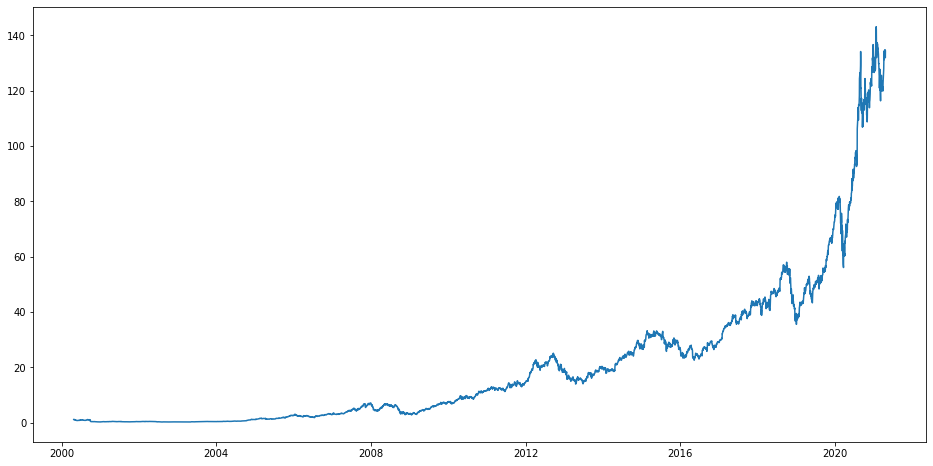

In [4]:
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date']

plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='Close Price history')

In [48]:
days_watching = 500
predict_days = 360
test_threshold = df.shape[0]-predict_days
# print(df.shape[0])

In [49]:
data = df.sort_index(ascending=True,axis=0)
df_new = pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])
for i in range(0,len(data)):
    df_new["Date"][i] = data['Date'][i]
    df_new["Close"][i] = data["Close"][i]
    
# print(df_new.head())
df_new.index = df_new.Date
df_new.drop("Date", axis=1, inplace=True)

final_dataset = df_new.values

train_data = final_dataset[0:test_threshold,:]
valid_data = final_dataset[test_threshold:,:]
# print(train_data[-10:])
# print()
# print(valid_data[-10:])

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(final_dataset)

x_train_data,y_train_data = [],[]

for i in range(days_watching,len(train_data)-predict_days):
    x_train_data.append(scaled_data[i-days_watching:i,0])
    y_train_data.append(scaled_data[i+predict_days,0])
# print(x_train_data[0])
# print(scaler.inverse_transform(np.reshape(x_train_data[0], (1, -1))))
# print()
# print(y_train_data[0])
# print(scaler.inverse_transform(np.reshape(y_train_data[0], (1, -1))))
# print(x_train_data[1])
# print()
# print(y_train_data[1])
x_train_data,y_train_data = np.array(x_train_data),np.array(y_train_data)

x_train_data = np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

In [56]:
lstm_model = Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True, input_shape=(x_train_data.shape[1],1)))
# lstm_model.add(LSTM(units=50,return_sequences=False, input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=128, return_sequences=True))
lstm_model.add(LSTM(units=64, return_sequences=False))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mse',optimizer='adam')
# lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=5,batch_size=500,verbose=2, shuffle=False)

Epoch 1/5
9/9 - 21s - loss: 0.0018
Epoch 2/5
9/9 - 21s - loss: 0.0181
Epoch 3/5
9/9 - 25s - loss: 0.0017
Epoch 4/5
9/9 - 25s - loss: 0.0046
Epoch 5/5
9/9 - 26s - loss: 0.0046


860 4923


<ipython-input-57-f6c1e7267cb1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions'] = closing_price


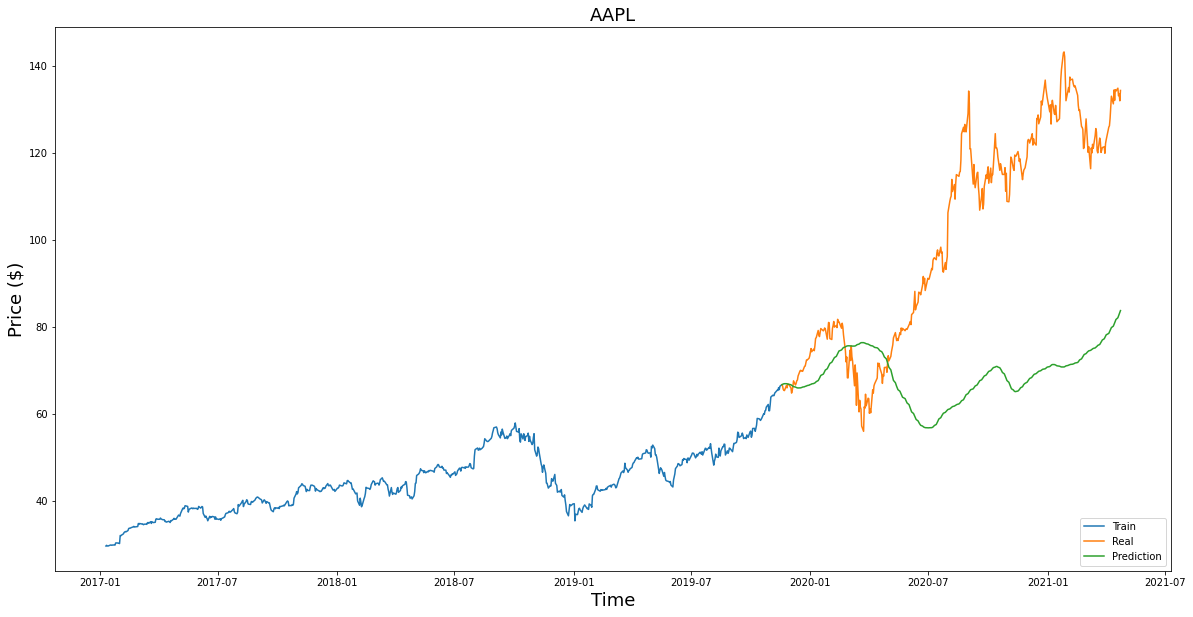

In [57]:
# inputs_data = df_new[0:].values
# inputs_data = df_new[len(df_new)-len(valid_data)-days_watching-predict_days:].values
inputs_data = df_new[len(df_new)-len(valid_data)-days_watching-predict_days:].values
inputs_data = inputs_data.reshape(-1,1)
inputs_data = scaler.transform(inputs_data)

# print("days in test", inputs_data.shape[0])
# base_q = []
# base_q.append(inputs_data[0:days_watching,0])
# print(base_q)
# print(base_q[0])
# close_predict = []

X_test=[]
print(inputs_data.shape[0]-predict_days, test_threshold)
# for i in range(days_watching,inputs_data.shape[0]-predict_days):
for i in range(days_watching,days_watching+predict_days):
    X_test.append(inputs_data[i-days_watching:i,0])
X_test=np.array(X_test)
# print(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
closing_price=lstm_model.predict(X_test)
closing_price=scaler.inverse_transform(closing_price)


# X_test = np.array(X_test)

# X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
# closing_price = lstm_model.predict(X_test)
# closing_price = scaler.inverse_transform(closing_price)
# print(X_test, "\n", closing_price)


train_data = df_new[:test_threshold+1]
valid_data = df_new[test_threshold:]
valid_data['Predictions'] = closing_price
first_vals = valid_data.iloc[0]
# print(first_vals)
valid_data = valid_data.sub([0, first_vals['Predictions']-first_vals['Close']], axis='columns')
# print(train_data)
# print(valid_data)
plt.title('AAPL', fontsize=18)
plt.xlabel('Time',fontsize=18)
plt.ylabel('Price ($)',fontsize=18)
plt.plot((train_data["Close"])[-2*predict_days:])
plt.plot((valid_data[['Close',"Predictions"]]))
plt.legend(['Train', 'Real', 'Prediction' ], loc='lower right')

lstm_model.save("saved_lstm_model.h5")
# model = keras.models.load_model('path/to/location')

[[0.420714]
 [0.419643]
 [0.414821]
 [0.414286]
 [0.406429]
 [0.383393]
 [0.353214]
 [0.35625]
 [0.373036]
 [0.368929]]
all: 5283
test count: 5013
5283 5013


<ipython-input-33-569e61fa16bf>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions'] = closing_price


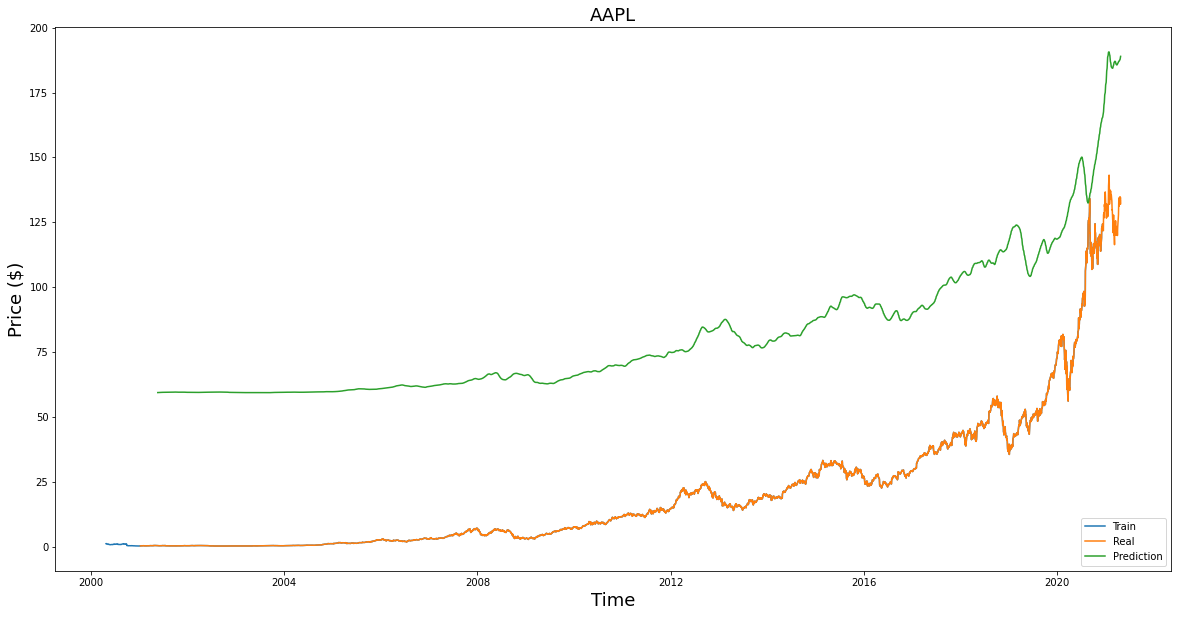

In [33]:
inputs_data = df_new[:].values
print(inputs_data[days_watching+predict_days: days_watching+predict_days+10])
inputs_data = inputs_data.reshape(-1,1)
inputs_data = scaler.transform(inputs_data)

X_test=[]
# for i in range(days_watching, days_watching+1):
for i in range(days_watching, inputs_data.shape[0]-predict_days):
    X_test.append(inputs_data[i-days_watching:i,0])
X_test=np.array(X_test)
# print(X_test)
# print(scaler.inverse_transform(X_test))

print("all:", inputs_data.shape[0])
print("test count:", X_test.shape[0])

X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
closing_price = lstm_model.predict(X_test)
# print('close:', closing_price)
closing_price = scaler.inverse_transform(closing_price)
# print('close inverse:', closing_price)
print(df_new.shape[0], closing_price.shape[0])
train_data = df_new[:test_threshold]
valid_data = df_new[-closing_price.shape[0]-predict_days:]


# print(closing_price[:10])
# closing_price = np.append(np.zeros(20) + np.nan, closing_price)
# print(np.full((predict_days, 1), np.nan))


closing_price = np.append(np.full((predict_days, 1), np.nan), closing_price)


# print(closing_price)
# preds = pd.DataFrame({'Predictions': closing_price[:, 0]})
# print(preds)
# print(valid_data)
# valid_data = pd.concat([valid_data, preds], axis=1)
# print(valid_data)

valid_data['Predictions'] = closing_price

# valid_data['Predictions'] = valid_data['Predictions'].shift(-predict_days)
# first_vals = valid_data.iloc[0]
# print(first_vals)
# valid_data = valid_data.sub([0, first_vals['Predictions']-first_vals['Close']], axis='columns')

plt.title('AAPL', fontsize=18)
plt.xlabel('Time',fontsize=18)
plt.ylabel('Price ($)',fontsize=18)
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])
plt.legend(['Train', 'Real', 'Prediction' ], loc='lower right')

lstm_model.save("saved_lstm_model.h5")
# model = keras.models.load_model('path/to/location')